In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [3]:
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metric

# Construct the secondary (fine-grain) classifier from OGLE/Const training set
## Import training/testing data

In [4]:
train_tot = pd.read_pickle('final_trainset.pkl')
print(set(list(np.array(train_tot['class']))))
print(len(train_tot))

{'CONST', 'Ell', 'EW', 'LYR_AB', 'LYR_CD', 'EA/EB'}
146293


/home/tam68/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f31a334ad68>]],
      dtype=object)

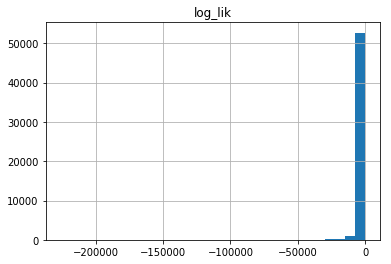

In [14]:
ew = train_tot.loc[train_tot['class']=='EW']
ew.drop(ew[ew['ls_period']>2.].index, inplace=True)
ew[['log_lik']].hist(bins=30)

In [17]:
train = train_tot.replace([np.inf, -np.inf], np.nan)
train = train.dropna(axis=0, how='any') 
print("{} total clipd set".format(len(train_tot)))
print("{} dropped clipd".format(len(train_tot)-len(train)))

146293 total clipd set
0 dropped clipd


In [18]:
def dist_classes(df):
    numb = []
    classes = set(list(np.array(df['class'])))
    class_ = np.array(df['class'])
    for i in classes:
        count=0
        for j in class_:
            if j == i:
                count+=1
            else:
                pass
        numb.append([i, count])
    for i in numb:
        print("{} {} in training set".format(i[1], i[0]))

In [19]:
print("-----")
dist_classes(train)

-----
54311 EW in training set
18305 LYR_AB in training set
28670 EA/EB in training set
8612 LYR_CD in training set
12749 Ell in training set
23646 CONST in training set


In [24]:
data_cols = ['a0_a1', 'a0_a2', 'a0_a3', 'a1_a2', 'a1_a3', 'a2_a3', 'phi0_phi1',
             'phi0_phi2','phi0_phi3', 'phi1_phi2', 'phi1_phi3', 'phi2_phi3','sd',
             'skew', 'kurtosis', 'amplitude', 'beyondfrac', 'med_magdev', 'log_lik',
             'ls_period','stetson_i', 'mags_q100mq0', 'mags_q99mq1', 'mags_q95mq5',
             'mags_q90mq10','mags_q75mq25','JK_col', 'HK_col']

target_cols = ['class']

X = train[data_cols]
y = train[target_cols]

### Pre-process data (random split/normalise)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Construct/Test Multilabel Classifier through crossvalidation

In [10]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=10, max_features='log2',
                                    max_depth=18, class_weight='balanced_subsample')
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

In [12]:
def classif_report(model, y_test, y_pred, X_test):
    print(metric.confusion_matrix(y_test,y_pred))
    print(metric.classification_report(y_test,y_pred))
    disp = metric.plot_confusion_matrix(model, X_test, y_test,
           cmap=plt.cm.Blues, normalize='true')
    fig = disp.figure_
    ax = disp.ax_
    im = disp.im_
    fig.set_size_inches(15,15)
    #fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
    matplotlib.rc('font', **font)
    ax.set_xlabel('Predicted label',family='serif', fontsize=17.5, labelpad=10)
    ax.set_ylabel('True label',family='serif', fontsize=17.5, labelpad=2)
    #ax.tick_params(labelsize=15)
    ticks_font = matplotlib.font_manager.FontProperties(family='serif',
                                                        style='normal', size=15,
                                                        weight='normal', stretch='normal')
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    return fig

[[ 5941     8     1     9     1     5]
 [   16  3665  2737   519   136    79]
 [   25  1076 11766   396   221   206]
 [   15   184   191  2608     9   109]
 [    0   139   219    80  4081     2]
 [    1    11    81    43     8  1986]]
              precision    recall  f1-score   support

       CONST       0.99      1.00      0.99      5965
       EA/EB       0.72      0.51      0.60      7152
          EW       0.78      0.86      0.82     13690
         Ell       0.71      0.84      0.77      3116
      LYR_AB       0.92      0.90      0.91      4521
      LYR_CD       0.83      0.93      0.88      2130

    accuracy                           0.82     36574
   macro avg       0.83      0.84      0.83     36574
weighted avg       0.82      0.82      0.82     36574



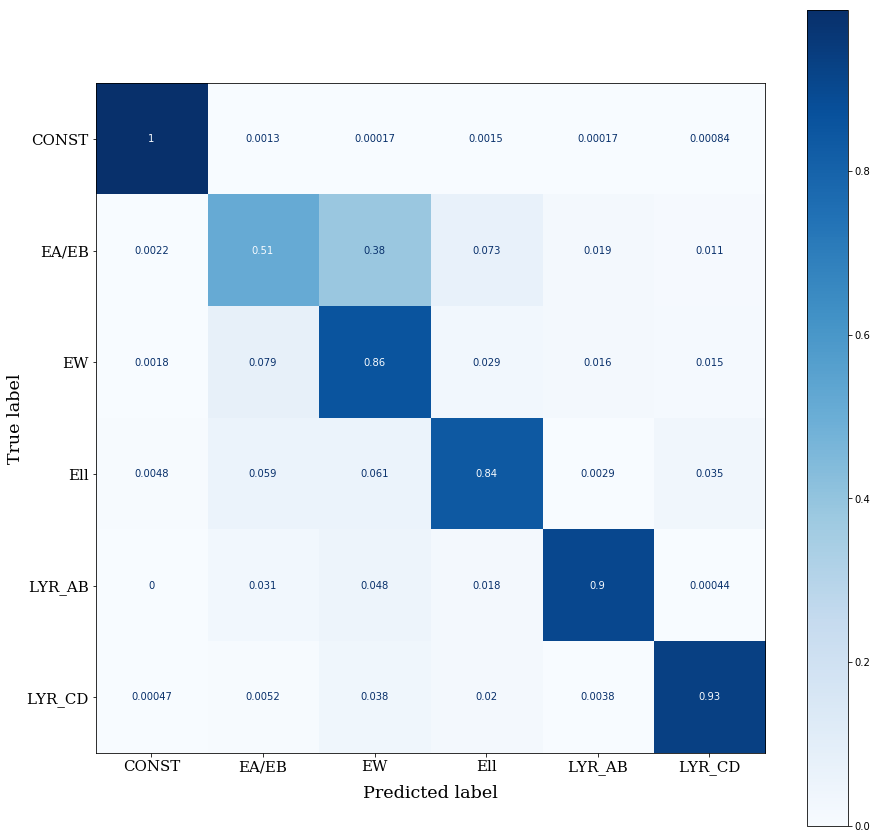

In [13]:
fig1 = classif_report(model, y_test, y_pred, X_test)

In [24]:
scores = cross_val_score(model, X, y.values.ravel(),
                               cv=10, scoring='accuracy', n_jobs=10)

mean, sd = np.mean(scores), np.std(scores)

print("{} +/- {} mean accuracy for clipd model".format(mean, sd))


0.8201582150732707 +/- 0.007251850638324696 mean accuracy for clipd model


### Check Feature Importance (for sanity)

In [26]:
features_dict = {}
for i in range(len(model.feature_importances_)):
    features_dict[data_cols[i]] = model.feature_importances_[i]

In [29]:
features_dict[r'LS period'] = features_dict.pop('ls_period')
features_dict[r'S.D.'] = features_dict.pop('sd')
features_dict[r'Stetson $I$'] = features_dict.pop('stetson_i')
features_dict[r'JK colour'] = features_dict.pop('JK_col')
features_dict[r'HK colour'] = features_dict.pop('HK_col')
features_dict[r'$R_{01}$'] = features_dict.pop('a0_a1')
features_dict[r'$R_{02}$'] = features_dict.pop('a0_a2')
features_dict[r'$R_{03}$'] = features_dict.pop('a0_a3')
features_dict[r'$R_{12}$'] = features_dict.pop('a1_a2')
features_dict[r'$R_{13}$'] = features_dict.pop('a1_a3')
features_dict[r'$R_{23}$'] = features_dict.pop('a2_a3')
features_dict[r'$\Phi_{01}$'] = features_dict.pop('phi0_phi1')
features_dict[r'$\Phi_{02}$'] = features_dict.pop('phi0_phi2')
features_dict[r'$\Phi_{03}$'] = features_dict.pop('phi0_phi3')
features_dict[r'$\Phi_{12}$'] = features_dict.pop('phi1_phi2')
features_dict[r'$\Phi_{13}$'] = features_dict.pop('phi1_phi3')
features_dict[r'$\Phi_{23}$'] = features_dict.pop('phi2_phi3')
features_dict[r'Amplitude'] = features_dict.pop('amplitude')
features_dict[r'$\Delta$ Log Likelihood'] = features_dict.pop('log_lik')
features_dict[r'Beyondfrac'] = features_dict.pop('beyondfrac')
features_dict[r'Skew'] = features_dict.pop('skew')
features_dict[r'Kurtosis'] = features_dict.pop('kurtosis')
features_dict[r'M.A.D'] = features_dict.pop('med_magdev')


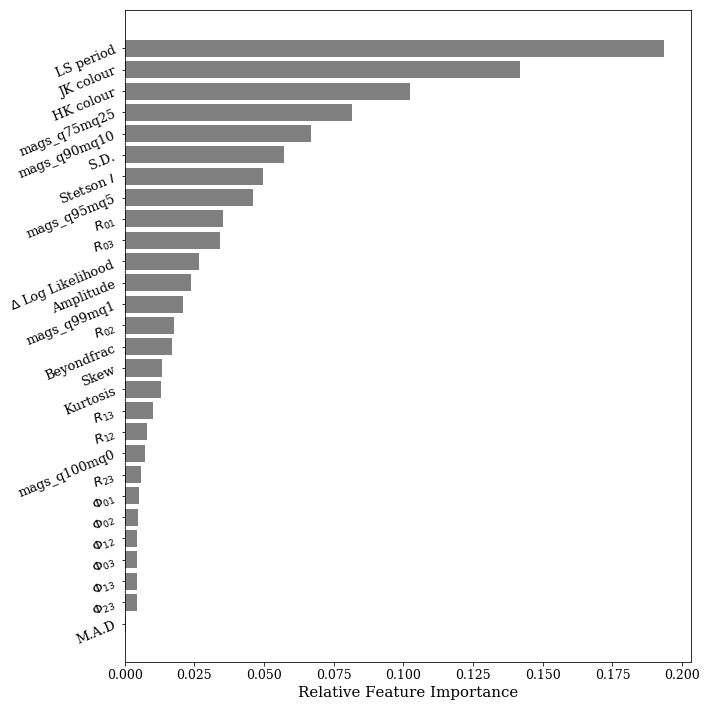

<module 'matplotlib.pyplot' from '/opt/ioa/software/anaconda/anaconda36/envs/20200218/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [31]:
def plot_imp(imp_dict):
    sort_dict = {k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}
    feat_names = list(sort_dict.keys())
    feat_imp = np.array(list(sort_dict.values()))
    y_pos = np.arange(len(feat_names))
#     ax_ = plt.barh(y_pos, feat_imp, align='center', color='k',alpha=0.5)
#     ax_ = plt.xticks(y_pos, feat_names)
#     ax_ = plt.ylabel('score')
#     ax_ = plt.title('Feature Importance')
    
    fig = plt.figure( figsize=(10,10))
    plt.barh(np.arange(0, len(feat_imp)), feat_imp, color='grey', align='center')
    plt.yticks(np.arange(0, len(feat_imp)), feat_names, rotation=22.5, family='serif', fontsize=13)
    plt.xlabel('Relative Feature Importance', family='serif', fontsize=15)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    fig.savefig('featureimportance.png')
    return plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12.5}

matplotlib.rc('font', **font)
plot_imp(features_dict)

### Accuracy vs. Training set size

In [127]:
scores_full = pd.read_pickle('clipd_scores.pkl')

In [165]:
def plot_scores(df_f):
    sizes_f = df_f['size']
    acc_f, acc_err_f = df_f['acc'], df_f['acc_err']
    f1_f, f1_err_f = df_f['f1'], df_f['f1_err']
    
    fig = plt.figure(figsize=(7.5,7.5))

    ax1 = fig.add_subplot(111)
    ax1.errorbar(x=np.array(sizes_f), y=np.array(acc_f), yerr=np.array(acc_err_f), c='r',alpha=0.5, label='accuracy score')
    ax1.errorbar(x=np.array(sizes_f), y=np.array(f1_f), yerr=np.array(f1_err_f), c='b',alpha=0.5, label='weighted F1 score')
    ax1.set_xlabel('Size of Training set', family='serif', fontsize=15)
    ax1.set_ylabel('Performance Metric', family='serif', fontsize=15)
    ax1.set_xlim(left=0)
    ax1.legend(loc='upper right', prop={'family': 'serif','size': 15})
#     ax2 = fig.add_subplot(122)
#     ax2 = plt.errorbar(x=np.array(sizes_f), y=np.array(f1_f), yerr=np.array(f1_err_f), c='b')
#     ax2 = plt.errorbar(x=np.array(sizes_t), y=np.array(f1_t), yerr=np.array(f1_err_t), c='r')
#     ax2 = plt.xlabel('Size of Training set')
#     ax2 = plt.ylabel('F1 metric (blue: clipd, red: trim)')
#     ax2 = plt.title('F1 score vs. Size full/trum training set')
    
    #fig.savefig('learningcurve.png')
    return fig

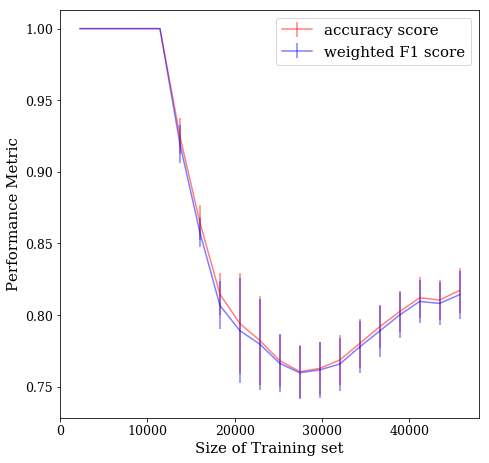

In [166]:
fig = plot_scores(scores_full)

### Probability tester

In [ ]:
prob_clipd = model_clipd.predict_proba(X_test_clipd)
prob_trim = model_trim.predict_proba(X_test_trim)

print(model_clipd.classes_)
print(model_trim.classes_)

# b307 Test Tile 

In [14]:
b334 = pd.read_pickle('b334_cand_feats.pkl')
b305 = pd.read_pickle('b305_cand_feats.pkl')

print(len(b334), len(b305))
print(b334.columns.values)

14862 37841
['vvv_id' 'class' 'features' 'a0' 'a1' 'a2' 'a3' 'phi0_phi1' 'phi0_phi2'
 'phi0_phi3' 'phi1_phi2' 'phi1_phi3' 'phi2_phi3' 'a0_a1' 'a0_a2' 'a0_a3'
 'a1_a2' 'a1_a3' 'a2_a3' 'mean' 'sd' 'skew' 'kurtosis' 'amplitude'
 'beyondfrac' 'med_magdev' 'log_lik' 'ls_period' 'lomb_period'
 'lomb_power' 'kepochs' 'stetson_i' 'mags_q100mq0' 'mags_q99mq1'
 'mags_q95mq5' 'mags_q90mq10' 'mags_q75mq25' 'vvv_sd' 'kmag' 'JK_col'
 'HK_col']


In [15]:
use305 = b305.replace([np.inf, -np.inf], np.nan)
use305 = use305.dropna(axis=0, how='any') 
use334 = b334.replace([np.inf, -np.inf], np.nan)
use334 = use334.dropna(axis=0, how='any') 
print("{} test1 {} test2 sources".format(len(use305), len(use334)))

37841 test1 14862 test2 sources


In [21]:
# Normalise test features to model specifications
sc_clipd = StandardScaler()

X_full_clipd = sc_clipd.fit_transform(X_clipd)

b305_norm = sc_clipd.transform(use305[data_cols])
b334_norm = sc_clipd.transform(use334[data_cols])

In [19]:
# Train full models
model_full_clipd = RandomForestClassifier(n_estimators=1000, min_samples_split=5,
                                          min_samples_leaf=5, max_features='sqrt',
                                    max_depth=18, class_weight='balanced_subsample')
model_full_clipd.fit(X_full_clipd, y_clipd.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=18, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [25]:
predict_b305 = model_full_clipd.predict(b305_norm)
predict_b334 = model_full_clipd.predict(b334_norm)

proba_b305 = model_full_clipd.predict_proba(b305_norm)
proba_b334 = model_full_clipd.predict_proba(b334_norm)

classes = model_full_clipd.classes_
print(classes)

['EA/EB' 'ELL' 'EW' 'RR Lyr ab' 'RR Lyr c/d']


In [26]:
print(set(list(predict_b334)))
print(set(list(predict_b305)))

{'RR Lyr c/d', 'ELL', 'EW', 'EA/EB', 'RR Lyr ab'}
{'RR Lyr c/d', 'ELL', 'EW', 'EA/EB', 'RR Lyr ab'}


In [63]:
use305.columns.values

array(['vvv_id', 'class', 'features', 'a0', 'a1', 'a2', 'a3', 'phi0_phi1',
       'phi0_phi2', 'phi0_phi3', 'phi1_phi2', 'phi1_phi3', 'phi2_phi3',
       'a0_a1', 'a0_a2', 'a0_a3', 'a1_a2', 'a1_a3', 'a2_a3', 'mean', 'sd',
       'skew', 'kurtosis', 'amplitude', 'beyondfrac', 'med_magdev',
       'log_lik', 'ls_period', 'lomb_period', 'lomb_power', 'kepochs',
       'stetson_i', 'mags_q100mq0', 'mags_q99mq1', 'mags_q95mq5',
       'mags_q90mq10', 'mags_q75mq25', 'vvv_sd', 'kmag', 'JK_col',
       'HK_col'], dtype=object)

In [58]:
def save_results(predict, df):
    source_ids = np.array(df.vvv_id.values, dtype='unicode_')
    ls_periods = np.array(df.ls_period.values)
    amplitude = np.array(df.amplitude.values)
    hk_col = np.array(df.HK_col.values)
    jk_col = np.array(df.JK_col.values)
    log_liks = np.array(df.log_lik.values)
    kmags = np.array(df.kmag.values)
    inp = {'prediction': predict, 'vvv_id':source_ids, 'period':ls_periods,
           'amplitude':amplitude, 'HK_col':hk_col, 'JK_col':jk_col,
           'log_lik':log_liks, 'kmag':kmags}
    df_predict = pd.DataFrame(data=inp)
    return df_predict

def count_predict(df, probs, name):
    classes = set(list(df.prediction.values))
    count = {}
    for i in classes:
        class_df = df.loc[df['prediction'] == i]
        count.update({'{}'.format(i):len(class_df)})
    
    prob_ew, prob_ea, prob_ell, prob_ab, prob_c_d = [],[],[],[],[]
    for i in probs:
        prob_ea.append(i[0])
        prob_ell.append(i[1])
        prob_ew.append(i[2])
        prob_ab.append(i[3])
        prob_c_d.append(i[4])
    
    df['prob_EW'] = pd.Series(prob_ew)
    df['prob_EA/EB'] = pd.Series(prob_ea)
    df['prob_ELL'] = pd.Series(prob_ell)
    df['prob_Lyr_AB'] = pd.Series(prob_ab)
    df['prob_Lyr_C/D'] = pd.Series(prob_c_d)
    
    df.to_pickle('{}_prediction.pkl'.format(name))
    return count

In [59]:
pred_b305 = save_results(predict_b305, use305)
pred_b334 = save_results(predict_b334, use334)

In [60]:
print(len(predict_b305), len(predict_b334))

37841 14862


In [61]:
count_b305 = count_predict(pred_b305, proba_b305, 'b305')
count_b334 = count_predict(pred_b334, proba_b334, 'b334')

In [62]:
print(count_b305)
print(count_b334)

{'RR Lyr c/d': 6, 'ELL': 284, 'EW': 24341, 'EA/EB': 13082, 'RR Lyr ab': 128}
{'RR Lyr c/d': 7, 'ELL': 480, 'EW': 6876, 'EA/EB': 7412, 'RR Lyr ab': 87}


In [32]:
result305 = pd.read_pickle('b305_prediction.pkl')
result334 = pd.read_pickle('b334_prediction.pkl')

## b334 candidate classification -- updated pipeline

In [25]:
cand = pd.read_pickle('b334cand_feats.pkl')

In [32]:
cand_use = cand.replace([np.inf, -np.inf], np.nan)
cand_use = cand_use.dropna(axis=0, how='any')
print("{}% sources left".format(100*round(len(cand_use)/len(cand))))
print(len(cand_use))

100% sources left
237843


In [29]:
print(data_cols)

['a0_a1', 'a0_a2', 'a0_a3', 'a1_a2', 'a1_a3', 'a2_a3', 'phi0_phi1', 'phi0_phi2', 'phi0_phi3', 'phi1_phi2', 'phi1_phi3', 'phi2_phi3', 'sd', 'skew', 'kurtosis', 'amplitude', 'beyondfrac', 'med_magdev', 'log_lik', 'ls_period', 'stetson_i', 'mags_q100mq0', 'mags_q99mq1', 'mags_q95mq5', 'mags_q90mq10', 'mags_q75mq25', 'JK_col', 'HK_col']


In [30]:
print(train.columns.values, cand_use.columns.values)

['class' 'a0_a1' 'a0_a2' 'a0_a3' 'a1_a2' 'a1_a3' 'a2_a3' 'phi0_phi1'
 'phi0_phi2' 'phi0_phi3' 'phi1_phi2' 'phi1_phi3' 'phi2_phi3' 'sd' 'skew'
 'kurtosis' 'amplitude' 'beyondfrac' 'med_magdev' 'log_lik' 'ls_period'
 'stetson_i' 'mags_q100mq0' 'mags_q99mq1' 'mags_q95mq5' 'mags_q90mq10'
 'mags_q75mq25' 'JK_col' 'HK_col'] ['period' 'amp_0' 'amp_1' 'amp_2' 'amp_3' 'phi_0' 'phi_1' 'phi_2' 'phi_3'
 'mean' 'sd' 'skew' 'kurt' 'amp' 'beyondfrac' 'med_magdev' 'delta_loglik'
 'sourceid' 'classname' 'skewness' 'kurtosis' 'stetson_i' 'eta'
 'mags_stdev' 'mags_mad' 'mags_min' 'mags_max' 'mags_q1' 'mags_q2'
 'mags_q4' 'mags_q8' 'mags_q16' 'mags_q32' 'mags_q50' 'mags_q68'
 'mags_q84' 'mags_q92' 'mags_q96' 'mags_q98' 'mags_q99' 'mags_q100mq0'
 'mags_q99mq1' 'mags_q95mq5' 'mags_q90mq10' 'mags_q75mq25' 'l' 'b' 'kmag'
 'jmag' 'hmag' 'JK_col' 'HK_col' 'phi0_phi1' 'phi0_phi2' 'phi0_phi3'
 'phi1_phi2' 'phi1_phi3' 'phi2_phi3' 'a0_a1' 'a0_a2' 'a0_a3' 'a1_a2'
 'a1_a3' 'a2_a3']


In [34]:
# Have to change columns names to match with training set (to be corrected)
cand_use['ls_period'] = np.array(cand_use['period'])
cand_use['amplitude'] = np.array(cand_use['amp'])
cand_use['log_lik'] = np.array(cand_use['delta_loglik'])

In [35]:
sc_full = StandardScaler()

X_full = sc_full.fit_transform(X)

b334_norm = sc_full.transform(cand_use[data_cols])

In [36]:
# Train full model
model_full_clipd = RandomForestClassifier(n_estimators=1000, min_samples_split=5,
                                          min_samples_leaf=5, max_features='sqrt',
                                    max_depth=18, class_weight='balanced_subsample')
model_full_clipd.fit(X_full, y.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=18, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [37]:
predict_b334 = model_full_clipd.predict(b334_norm)
proba_b334 = model_full_clipd.predict_proba(b334_norm)

In [44]:
print(model_full_clipd.classes_)

['CONST' 'EA/EB' 'EW' 'Ell' 'LYR_AB' 'LYR_CD']


In [47]:
def save_results(predict, predict_probs, df):
    
    # Divide probability outputs into the relevant classes, following the order in the _classes attribute
    prob_const = [i[0] for i in predict_probs]
    prob_ea_eb = [i[1] for i in predict_probs]
    prob_ew = [i[2] for i in predict_probs]
    prob_ell = [i[3] for i in predict_probs]
    prob_lyr_ab = [i[4] for i in predict_probs]
    prob_lyr_cd = [i[5] for i in predict_probs]
    
    inp = {'sourceid':df.sourceid.values,'prediction':predict, 'prob_const':prob_const, 'prob_ea_eb':prob_ea_eb,
           'prob_ew':prob_ew, 'prob_ell':prob_ell, 'prob_lyr_ab':prob_lyr_ab, 'prob_lyr_cd':prob_lyr_cd,
           'period':df.ls_period.values, 'amplitude':df.amplitude.values, 'HK_col':df.HK_col.values,
           'JK_col':df.JK_col.values,'log_lik':df.log_lik.values, 'kmag':df.kmag.values}
    
    df_predict = pd.DataFrame(data=inp)
    
    classes = set(list(df_predict.prediction.values))
    count = {}
    for i in classes:
        class_df = df.loc[df_predict['prediction'] == i]
        count.update({'{}'.format(i):len(class_df)})
        
    print(count)
    
    return df_predict

In [48]:
df_predict = save_results(predict_b334, proba_b334, cand_use)

{'EW': 57582, 'LYR_AB': 274, 'LYR_CD': 8714, 'Ell': 5149, 'EA/EB': 21125, 'CONST': 144999}


In [59]:
df_predict.to_pickle('b334_class_predict.pkl')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa702453198>]],
      dtype=object)

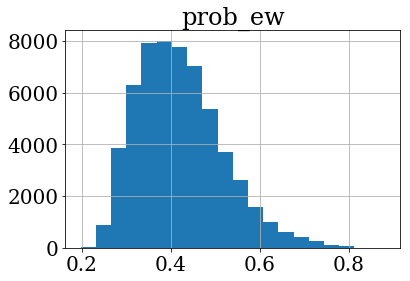

In [50]:
df_ew = df_predict.loc[df_predict['prediction']=='EW']
df_ew_probs = df_ew[['prob_ew']]
df_ew_probs.hist(bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6808afbe0>]],
      dtype=object)

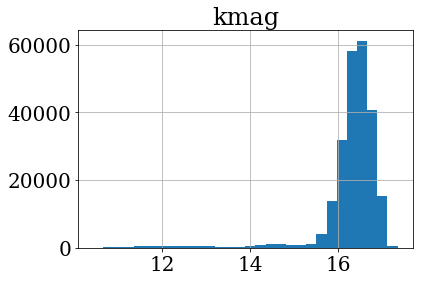

In [58]:
mags = cand_use[['kmag']]
mags.hist(bins=30)

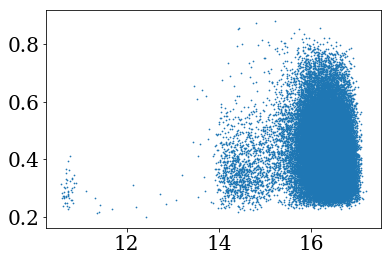

In [57]:
plt.scatter(df_ew.kmag.values, df_ew.prob_ew.values, s=0.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa680a5f5f8>]],
      dtype=object)

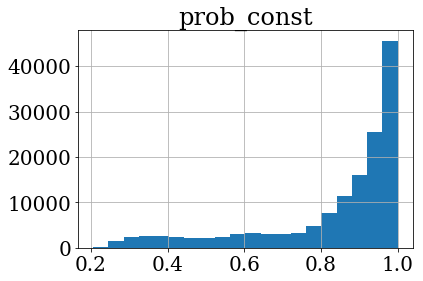

In [52]:
df_const = df_predict.loc[df_predict['prediction']=='CONST']
df_const_probs = df_const[['prob_const']]
df_const_probs.hist(bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa68095b518>]],
      dtype=object)

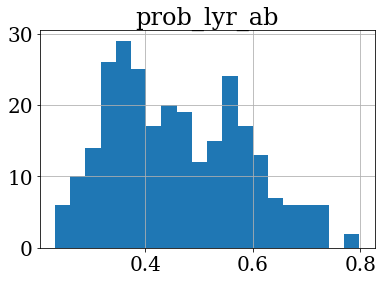

In [55]:
df_ab = df_predict.loc[df_predict['prediction']=='LYR_AB']
df_ab_probs = df_ab[['prob_lyr_ab']]
df_ab_probs.hist(bins=20)

## Test classification on VVV variable star catalogue for results

In [20]:
from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table
from sqlutilpy import *


In [17]:
ident = get_pkg_data_filename('vvvCat.fits')
entries = Table.read(ident)

In [18]:
print(entries)

   VIVAID            RA                 DEC           BESTPERIOD 
                  RADIANS             RADIANS                    
------------ ------------------ -------------------- ------------
515519330028  4.652940997200828  -0.5018708635517275 345.35276058
515519280696  4.663925969503304  -0.4803465022570459   0.09454535
515518798181  4.645760395653971  -0.4956805594208793   0.99224149
515518570314  4.646229567558576 -0.49053969842896716   2.48802563
515518188095  4.647251330548757  -0.4910518190537211     0.125164
515518092560  4.650547369220451  -0.5001789787161636   0.14102232
515518088306  4.654207705161113  -0.5024883037523957   3.61016565
515497501558  4.666458686611496 -0.47958863792447165  414.1009661
515518164765  4.658270638451808  -0.4987089470399077   0.36389253
515519990393  4.667106260661719  -0.4856305811695401   0.03333976
         ...                ...                  ...          ...
515518420551  4.668325617734679  -0.4854104381658636  13.09416921
5155181940

In [28]:
import math

In [27]:
ra_rad = np.array(entries['RA'])
dec_rad = np.array(entries['DEC'])

In [31]:
ra_deg = np.degrees(ra_rad)
dec_deg = np.degrees(dec_rad)

In [22]:
wsdb_kwargs = {'host':'cappc127',
               'user':'thomas_molnar',
               'password':'00NOuNZ12!',
               'asDict':True,
               'preamb':
                'set enable_seqscan to off; set enable_mergejoin to off; set enable_hashjoin to off;',
               'db':'wsdb'}

In [32]:
def cm_virac(data, cm_radius=1.):
    print("Loading cross-match... ")
    ra = data[0]
    dec = data[1]
    star = data[2]
    decaps = sqlutil.local_join("""
                select * from mytable as m
                left join lateral (select *, q3c_dist(m.ra_, m.dec_, s.ra, s.dec) from leigh_smith.virac_pm2_jhk as s
                where q3c_join(m.ra_, m.dec_, s.ra, s.dec,{0}/3600) 
                order by q3c_dist(m.ra_, m.dec_, s.ra, s.dec) asc limit 1)
                as tt on  true  order by xid """.format(cm_radius),
                'mytable',(ra,dec,np.arange(len(dec)), star),('RA_','DEC_', 'xid', 'VIVAID'),**wsdb_kwargs)
    decaps = pd.DataFrame(decaps)
    print("Cross match complete.")
    return decaps

In [25]:
test = pd.DataFrame(sqlutil.get("""
                    select * from leigh_smith.virac_pm2_jhk
                    where sourceid in {}
                    """.format(tuple(entries['VIVAID'])), **wsdb_kwargs))

In [33]:
cm = cm_virac([ra_deg, dec_deg, entries['VIVAID']])

Loading cross-match... 
Cross match complete.


In [35]:
print(cm.dropna())

             ra_       dec_   xid        vivaid      sourceid          ra  \
5     266.456737 -28.658144     5  515518092560  582902231110  266.456784   
6     266.666458 -28.790459     6  515518088306  581878002571  266.666473   
8     266.899247 -28.573918     8  515518164765  581879146386  266.899240   
37    267.594497 -27.721879    37  515518462129  576761119549  267.594498   
41    267.033014 -27.806850    41  515518356185  577783104958  267.032983   
...          ...        ...   ...           ...           ...         ...   
1471  266.834594 -28.782512  1471  515518521530  582903133074  266.834582   
1472  267.090447 -27.446928  1472  515518464661  574712036958  267.090417   
1474  266.397484 -28.174775  1474  515518194044  578806341071  266.397498   
1476  266.524186 -28.567290  1476  515518119477  580854316717  266.524199   
1477  266.927922 -28.845953  1477  515518105728  582903076135  266.927896   

            dec        era       edec         l  ...  mags_q96  mags_q98  \